# Задание 1. A/B–тестирование


1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

1.2 Входные данные

В качестве входных данных вы имеете 4 csv-файла:

groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups_add.csv – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента. 


А – контроль, B – целевая группа

In [1]:
import pandas as pd
import numpy as np

import requests
from urllib.parse import urlencode

from tqdm.auto import tqdm
from scipy.stats import norm 

import seaborn as sns
import matplotlib.pyplot as plt

import re

import pandahouse as ph

In [2]:
# получаем прямую ссылку на файлы
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'


# ссылки на данные с указанием разделителя csv-файла
links_dic = {
    'groups':       ['https://disk.yandex.ru/d/UhyYx41rTt3clQ', ';'],
    'groups_add':   ['https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', ','],
    'active_studs': ['https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', ','],
    'checks':       ['https://disk.yandex.ru/d/pH1q-VqcxXjsVA', ';']
            }

# скачиваем файлы
for csv_filename, csv_link in links_dic.items():
    final_url               = base_url + urlencode(dict(public_key=csv_link[0]))
    response                = requests.get(final_url)
    download_url            = response.json()['href']
    globals()[csv_filename] = pd.read_csv(download_url, sep=csv_link[1])

Данные скачались и открываются, теперь посмотрим сами таблички

In [3]:
groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


In [4]:
groups.id.nunique

<bound method IndexOpsMixin.nunique of 0           1489
1           1627
2           1768
3           1783
4           1794
          ...   
74479    5692459
74480    5692572
74481    5692865
74482    5693667
74483    5694419
Name: id, Length: 74484, dtype: int64>

In [5]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [6]:
groups_add

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [7]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [8]:
groups_add.id.nunique()

92

In [9]:
active_studs

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


In [10]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [11]:
active_studs.student_id.nunique()

8341

In [12]:
checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [13]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [14]:
checks.student_id.nunique()

541

Сверяем есть ли неучтеные данные из groups_add в active_studs и checks:

In [15]:
print('Количество учтенных ID в active_studs:', groups_add.query('id in @active_studs.student_id').shape[0], 
      '\nКоличество учтенных ID в checks:',     groups_add.query('id in @checks.student_id').shape[0])

Количество учтенных ID в active_studs: 13 
Количество учтенных ID в checks: 1


Мерджим groups с groups_add раз оказалось несколько неучтенных студентов

In [16]:
groups_total = pd.concat([groups, groups_add])
print('Было:', groups_add.id.count() + groups.id.count(), 
      '\nПосле соединения:', pd.concat([groups, groups_add]).id.count(),
      '\nВерно' if groups_add.id.count() + groups.id.count() == groups_total.id.count()
                    else '\nОшибка') #Проводим проверку кол-ва строк что все верно присоединилось

Было: 74576 
После соединения: 74576 
Верно


In [17]:
print('Распределение пользователей по группам: \nГруппа A:', 
      groups_total.grp.value_counts()[1], '\nГруппа B:',
      groups_total.grp.value_counts()[0], '\nВсего:   ',
      groups_total.grp.value_counts()[1] +
      groups_total.grp.value_counts()[0])

Распределение пользователей по группам: 
Группа A: 14693 
Группа B: 59883 
Всего:    74576


In [18]:
paid_not_active = checks.query('student_id not in @active_studs.student_id')
print('Количество пользователей из списка активных, но не вошедших в общий:', 
      active_studs.query('student_id not in @groups_total.id').shape[0],
      '\nКоличество оплативших пользователей, но отсутствующих в общем списке:',
      checks.query('student_id not in @groups_total.id').shape[0],
      '\nКоличество оплативших пользователей, но отсутствующих в списке активных в дни тестирования:',
      paid_not_active.shape[0])

Количество пользователей из списка активных, но не вошедших в общий: 0 
Количество оплативших пользователей, но отсутствующих в общем списке: 0 
Количество оплативших пользователей, но отсутствующих в списке активных в дни тестирования: 149


In [19]:
print('Распредление checks по группам: \nГруппа A:', 
      groups_total.query('id in @checks.student_id').grp.value_counts()[0], '\nГруппа B:',
      groups_total.query('id in @checks.student_id').grp.value_counts()[1], '\nВсего:   ', 
      groups_total.query('id in @checks.student_id').grp.value_counts()[0] + 
      groups_total.query('id in @checks.student_id').grp.value_counts()[1])

Распредление checks по группам: 
Группа A: 434 
Группа B: 107 
Всего:    541


In [20]:
print('Оплатили, но не в списке активных, количество по группам:\nГруппа A:', 
      groups_total.query('id in @paid_not_active.student_id').grp.value_counts()[1], '\nГруппа B:',
      groups_total.query('id in @paid_not_active.student_id').grp.value_counts()[0], '\nВсего:   ',
      groups_total.query('id in @paid_not_active.student_id').grp.value_counts()[1] + 
      groups_total.query('id in @paid_not_active.student_id').grp.value_counts()[0])

Оплатили, но не в списке активных, количество по группам:
Группа A: 29 
Группа B: 120 
Всего:    149


In [21]:
print('Распределение active_studs по группам: \nГруппа A:', 
      groups_total.query('id in @active_studs.student_id').grp.value_counts()[1], '\nГруппа B:',
      groups_total.query('id in @active_studs.student_id').grp.value_counts()[0], '\nВсего:   ',
      groups_total.query('id in @active_studs.student_id').grp.value_counts()[1] + 
      groups_total.query('id in @active_studs.student_id').grp.value_counts()[0])

Распределение active_studs по группам: 
Группа A: 1538 
Группа B: 6803 
Всего:    8341


In [22]:
print('Активные оплатившие пользователи, количество по группам: \nГруппа A:', 
      groups_total.query('id in @active_studs.student_id & id in @checks.student_id').grp.value_counts()[1], '\nГруппа B:',
      groups_total.query('id in @active_studs.student_id & id in @checks.student_id').grp.value_counts()[0], '\nВсего:   ',
      groups_total.query('id in @active_studs.student_id & id in @checks.student_id').grp.value_counts()[1] +
      groups_total.query('id in @active_studs.student_id & id in @checks.student_id').grp.value_counts()[0])

Активные оплатившие пользователи, количество по группам: 
Группа A: 78 
Группа B: 314 
Всего:    392


In [23]:
print('Активные, но не оплатившие пользователи, количество по группам: \nГруппа A:', 
      groups_total.query('id in @active_studs.student_id & id not in @checks.student_id').grp.value_counts()[1], '\nГруппа B:',
      groups_total.query('id in @active_studs.student_id & id not in @checks.student_id').grp.value_counts()[0], '\nВсего:   ',
      groups_total.query('id in @active_studs.student_id & id not in @checks.student_id').grp.value_counts()[1] +
      groups_total.query('id in @active_studs.student_id & id not in @checks.student_id').grp.value_counts()[0])

Активные, но не оплатившие пользователи, количество по группам: 
Группа A: 1460 
Группа B: 6489 
Всего:    7949


Таким образом, у нас есть:
1) активные пользователи;
2) посетители сайта в дни проведения теста;
3) пользователи, которые совершили платежи. 
Активные с оплатившими пересекаются частично, а пользователи, которые оплатили, но не попали в список активных, вореятно осуществили автоплатеж или что-то подобное или просто ошибочно попали в этот список, в целом это является некой аномалией и мы убераем их из выборки оплативших не активных. Т.е. оплативших будем брать только тех, одновременно является и оплатившим, и активным (пересечение active_studs и checks - 392 человека).

In [24]:
active_checks = (
                active_studs
                .merge(checks, how='left', on='student_id')
                .rename(columns={'student_id': 'id'})
                )
active_checks.query('rev.notna()')

,id,rev
62,1184303,1530.0000
67,3354191,1900.0001
77,3278734,1900.0000
99,720651,1980.0000
193,1232221,1900.0000
...,...,...
8201,3890326,199.0000
8204,1390994,398.0000
8263,1516339,290.0000
8277,3910596,597.0000


In [25]:
active_total = groups_total.merge(active_checks, how='right', on='id') 
active_total['payment'] = active_total.rev.apply(lambda x: 0 if np.isnan(x) else 1)
active_total.query('rev.isna()')
active_total['rev'] = active_total.rev.fillna(0)
active_total
#оставляем только активных + сделаем фильтр по оплате, где (0 - не оплачен, 1 - оплачен)

,id,grp,rev,payment
0,581585,A,0.0,0
1,5723133,A,0.0,0
2,3276743,B,0.0,0
3,4238589,A,0.0,0
4,4475369,B,0.0,0
...,...,...,...,...
8336,1794344,B,0.0,0
8337,296883,B,0.0,0
8338,3598448,B,0.0,0
8339,3610547,B,290.0,1


In [26]:
#Активные и оплатившие:
active_total_pay = active_total.query('rev > 0')
active_total_pay

,id,grp,rev,payment
62,1184303,A,1530.0000,1
67,3354191,B,1900.0001,1
77,3278734,B,1900.0000,1
99,720651,A,1980.0000,1
193,1232221,B,1900.0000,1
...,...,...,...,...
8201,3890326,B,199.0000,1
8204,1390994,A,398.0000,1
8263,1516339,A,290.0000,1
8277,3910596,B,597.0000,1


Делим по группам:

In [27]:
a_group = active_total.query('grp == "A"')
a_group

,id,grp,rev,payment
0,581585,A,0.0,0
1,5723133,A,0.0,0
3,4238589,A,0.0,0
7,1394612,A,0.0,0
21,5194768,A,0.0,0
...,...,...,...,...
8317,3208984,A,0.0,0
8320,2900558,A,0.0,0
8326,1161774,A,0.0,0
8330,5006972,A,0.0,0


In [28]:
a_group_pay = a_group.query('rev > 0')
a_group_pay

,id,grp,rev,payment
62,1184303,A,1530.0,1
99,720651,A,1980.0,1
306,4337103,A,580.0,1
392,332387,A,2910.0,1
439,1659434,A,690.0,1
...,...,...,...,...
7950,445767,A,3660.0,1
8025,1202202,A,2910.0,1
8027,2306271,A,290.0,1
8204,1390994,A,398.0,1


In [29]:
b_group = active_total.query('grp == "B"')
b_group

,id,grp,rev,payment
2,3276743,B,0.0,0
4,4475369,B,0.0,0
5,5481015,B,0.0,0
6,1353433,B,0.0,0
8,1170611,B,0.0,0
...,...,...,...,...
8336,1794344,B,0.0,0
8337,296883,B,0.0,0
8338,3598448,B,0.0,0
8339,3610547,B,290.0,1


In [30]:
b_group_pay = b_group.query('rev > 0')
b_group_pay

,id,grp,rev,payment
67,3354191,B,1900.0001,1
77,3278734,B,1900.0000,1
193,1232221,B,1900.0000,1
195,3821501,B,1900.0000,1
211,1036096,B,1900.0000,1
...,...,...,...,...
8109,2692209,B,1900.0001,1
8191,2081846,B,1900.0000,1
8201,3890326,B,199.0000,1
8277,3910596,B,597.0000,1


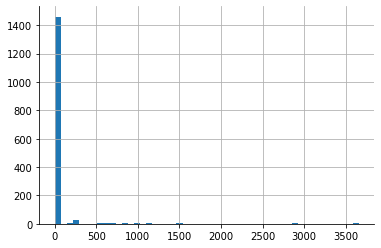

In [31]:
a_group.rev.hist(bins=50)
sns.despine() #Распределение группы А

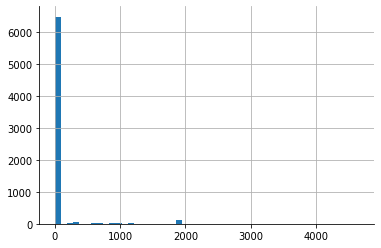

In [32]:
b_group.rev.hist(bins=50)
sns.despine() #Распределение группы B

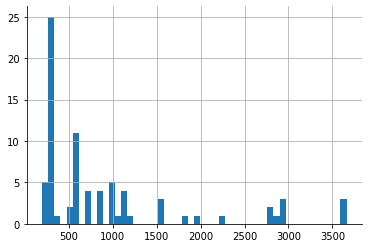

In [33]:
a_group_pay.rev.hist(bins=50)
sns.despine()#Распределение группы А с оплатой

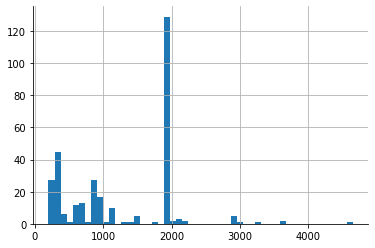

In [34]:
b_group_pay.rev.hist(bins=50)
sns.despine() #Распределение группы В с оплатой

In [35]:
a_group_descr = a_group.rev.describe().to_frame().rename(columns={'rev': 'Группа В'})
b_group_descr = b_group.rev.describe().to_frame().rename(columns={'rev': 'Группа А'})
pd.concat([a_group_descr, b_group_descr], axis=1) #Сравним две группы Describe

,Группа В,Группа А
count,1538.000000,6803.000000
mean,47.347204,58.058798
std,290.490632,313.770201
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,3660.000000,4650.000000


In [36]:
a_group_descr = a_group_pay.rev.describe().to_frame().rename(columns={'rev': 'Группа А'})
b_group_descr = b_group_pay.rev.describe().to_frame().rename(columns={'rev': 'Группа В'})
pd.concat([a_group_descr, b_group_descr], axis=1) #Теперь сравним две группы с оплатой

,Группа А,Группа В
count,78.000000,314.000000
mean,933.589744,1257.878992
std,919.932711,790.864254
min,199.000000,199.000000
25%,290.000000,511.750000
50%,585.000000,1140.000000
75%,1114.750000,1900.000000
max,3660.000000,4650.000000


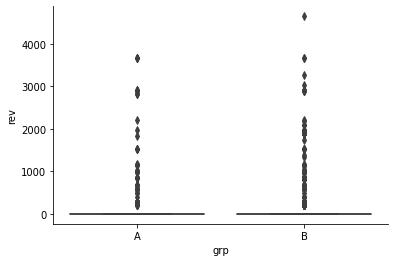

In [37]:
sns.boxplot(data=active_total, y='rev', x='grp')
sns.despine() #Смотрим выбросы по группам

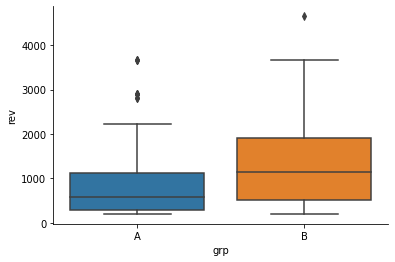

In [38]:
sns.boxplot(data=active_total_pay, y='rev', x='grp')
sns.despine() #теперь с учетом оплаты

1.3 Вопросы

Предлагаем вам ответить на следующие вопросы:

На какие метрики вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?
_________________________________________________________________________

Для анализа подойдут следующие метрики:

CR (конверсия платежей) - отношение количества оплативших клиентов к общему числу активных клиентов. CR выше в том варианте, где пользователю проще проивзести оплату.
ARPU - отношение общей суммы на количество активных пользователей. Увеличение этого показателя - бизнес получает больше денег.
ARPPU - отношение общей суммы на количество активных оплативших пользователей. Увеличение этого показателя - бизнес получает больше денег.

In [39]:
print('\033[1mCR \033[0m\nКонверсия оплативших пользователей:\nГруппа А:', 
                                             round(a_group_pay.id.count() / a_group.id.count(), 4),
                                             '\nГруппа В:', 
                                             round(b_group_pay.id.count() / b_group.id.count(), 4),
      '\nКонверсия у группы B на', abs(round((round(b_group_pay.id.count() / b_group.id.count(), 4) - 
                                   round(a_group_pay.id.count() / a_group.id.count(), 4)) / 
                                   round(a_group_pay.id.count() / a_group.id.count(), 4), 3) * 100), '%',
      'больше, чем у группы А' if round((round(b_group_pay.id.count() / b_group.id.count(), 4) - 
                                  round(a_group_pay.id.count() / a_group.id.count(), 4)) / 
                                  round(a_group_pay.id.count() / a_group.id.count(), 4), 3) * 100 > 0 
                               else 'меньше, чем у группы А')

print('\n\033[1mARPPU \033[0m\nОтношение общей суммы на количество активных оплативших пользователей:\nГруппа А:',
                                                                                      round(a_group_pay.rev.mean(), 2), 
                                                                                     '\nГруппа В:', 
                                                                                      round(b_group_pay.rev.mean(), 2),
      '\nARPPU группы В на', round(round(b_group_pay.rev.mean() - a_group_pay.rev.mean(), 2) /
                             round(a_group_pay.rev.mean(), 2) * 100, 2),'%',
      'больше, чем у группы А' if round(round(b_group_pay.rev.mean() - a_group_pay.rev.mean(), 2) /
                                  round(a_group_pay.rev.mean(), 2) * 100, 2) > 0 
                               else 'меньше, чем у группы А/n')

print('\n\033[1mARPU\033[0m\nОтношение общей суммы на количество активных пользователей:\nГруппа А:',
                                                                          round(a_group_pay.rev.sum() / a_group.id.count(), 2),
                                                                          '\nГруппа В:', 
                                                                          round(b_group_pay.rev.sum() / b_group.id.count(), 2),
      '\nARPU группы В на', 
      round((round(b_group_pay.rev.sum() / b_group.id.count(), 2) - round(a_group_pay.rev.sum() / a_group.id.count(), 2)) /
      round(a_group_pay.rev.sum() / a_group.id.count(), 2) * 100, 2), '%',
      'больше, чем у группы А' if 
      round((round(b_group_pay.rev.sum() / b_group.id.count(), 2) - round(a_group_pay.rev.sum() / a_group.id.count(), 2)) /
      round(a_group_pay.rev.sum() / a_group.id.count(), 2) * 100, 2) > 0
                               else 'меньше, чем у группы А')

CR 
Конверсия оплативших пользователей:
Группа А: 0.0507 
Группа В: 0.0462 
Конверсия у группы B на 8.9 % меньше, чем у группы А

ARPPU 
Отношение общей суммы на количество активных оплативших пользователей:
Группа А: 933.59 
Группа В: 1257.88 
ARPPU группы В на 34.74 % больше, чем у группы А

ARPU
Отношение общей суммы на количество активных пользователей:
Группа А: 47.35 
Группа В: 58.06 
ARPU группы В на 22.62 % больше, чем у группы А


Конверсия падает, но доход на пользователя растёт.

Наши группы А и В сильно отличаются по размеру, поэтому нам подходит метод bootstrap.

Строим bootstrap для групп А и B.
Вычисляем их разницу.
В получившемся рапределении разницы находим доверительных интервал.
Проверяем, попадает ли доверительный интервал в 0. Если да, то нулевая гипотеза на данном уровне значимости принимается, если нет - отвергается.

In [40]:
# функция для проверки гипотез с помощью бутстрапа
def get_bootstrap(
    data_column_1,                       # числовые значения первой (контрольной) выборки
    data_column_2,                       # числовые значения второй (тестовой) выборки
    boot_it   = 1000,                    # количество бутстрэп-выборок
    statistic = np.mean,                 # интересующая статистика
    bootstrap_conf_level = 0.95,         # уровень значимости
    graph         = True,                # отрисовать график
    show_progress = True                 # показать индикатор прогресса
    ):
    boot_len  = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
      # выбираем рисовывать индикатора прогресса или нет
    if show_progress:
        progress_bar = tqdm
    else:
        progress_bar = lambda x: x
    
    for i in progress_bar(range(boot_it)):        # извлекаем выборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        samples_delta = samples_2 - samples_1      # находим разницу подвыборок
        boot_data.append(statistic(samples_delta)) # применяем статистику для разниц подвыборок
        
    pd_boot_data = pd.DataFrame(boot_data)
    
     # доверительный интервал 
    left_quant  = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x     = 0, 
        loc   = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x     = 0, 
        loc   = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
     # графики
    if graph == True:
        plt.hist(pd_boot_data[0], bins = 50)
        plt.style.use('ggplot')
        plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()
       
    return {"ci": ci, 
            "p_value": p_value}

In [41]:
#Функции для метрик:
def cr_func(x):
    '''
    CR
    Для корректной работы функции в качестве аргумента "х" 
    необходимо передать серию со значениями 1 и 0, или True и False,
    в соответствии с тем произошло ожидаемое событие или нет.
    '''
    return sum(x) / len(x)

def arpu_func(y):
    '''
    ARPU
    Для корректной работы функции в качестве аргумента "y" 
    необходимо передать серию, где все NaN-значения заменены на 0
    '''
    return np.mean(y)

def arppu_func(y):
    '''
    ARPPU
    Для корректной работы функции в качестве аргумента "y" 
    необходимо передать серию, где отобраны только платежи, т.е. отфильтрованы 0
    или вместо 0 стоят NaN.
    '''
    return np.mean(y)

CR

Сформулируем нулевую и альтернативную гипотезы:

H0: CR в двух группах одинаковые.
H1: CR в двух группах различаются.
___________________________________________________________

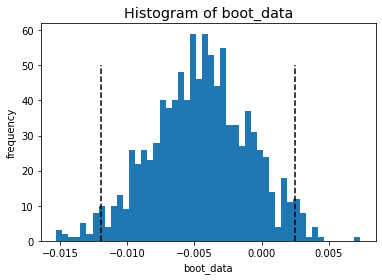

{'ci':               0
 0.025 -0.011910
 0.975  0.002499,
 'p_value': 0.20691938677927435}

In [42]:
get_bootstrap(a_group.payment, b_group.payment, statistic = cr_func)

Видим, что доверительный интервал попадает в 0, недостаточно оснований отвергнуть нулевую гипотезу,при этом нельзя утверждать, что различия CR в двух группах есть.

_______________________________________________________
ARPU

Сформулируем нулевую и альтернативную гипотезы:

H0: ARPU в двух группах одинаковые.
H1: ARPU в двух группах различаются.

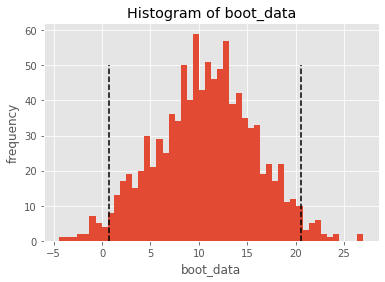

{'ci':                0
 0.025   0.742235
 0.975  20.514505,
 'p_value': 0.03555076478652002}

In [43]:
get_bootstrap(a_group.rev, b_group.rev, statistic = arpu_func)

Доверительный интервал не попадает в 0, отвергаем нулевую гипотезу. ARPU в двух группах различаются.

____________________________________________
ARPPU

Сформулируем нулевую и альтернативную гипотезы:

H0: ARPPU в двух группах одинаковые.
H1: ARPPU в двух группах различаются.

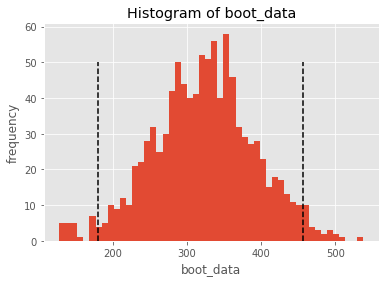

{'ci':                 0
 0.025  179.993882
 0.975  456.028995,
 'p_value': 2.4116942392212565e-06}

In [44]:
get_bootstrap(a_group.rev[a_group.rev > 0], b_group.rev[b_group.rev > 0], statistic = arppu_func)

Доверительный интервал не попадает в 0, отвергаем нулевую гипотезу. ARPPU в двух группах различаются.

Стоит ли запускать новую механику на всех пользователей?
А – контроль, B – целевая группа
_________________________________________________________________

Стоит, потому что новая механика дает статистически значимую прибавку в метриках ARPU и ARPPU, а отрицательное изменение CR тестом не подтвеждается.

# Задание 2. SQL

2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.


2.1.2 Задача

Дана таблица default.peas:

Название атрибута	Тип атрибута	Смысловое значение
st_id	int	ID ученика
timest	timestamp	Время решения карточки
correct	bool	Правильно ли решена горошина?
subject	text	Дисциплина, в которой находится горошина


Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

_____________
Согласно поставленной задаче, мы имеем:

карточки = задания = горошины

студент = ученик

усердный - 20 горошин (карточек / заданий) в месяц

______________

Посмотрим за какой период вообще у нас есть данные т.к. в задании сказано что нам надо отобрать студентов за текущий месяц, котроые правильно решили хотя бы 20 "горошин" (текущим месяцем, наверное,является последний) и надо его идентифицировать. Но в данных оказалось супер много записей и просто выгрузить все и отсортировать по убыванию не получается. 
Нужно сделать столбец с датой (отбросив время) и посмотреть как наши данные распределены по месяцам:

ДАТА: 2021-10-30	КОЛ-ВО ЗАПИСЕЙ: 5509

ДАТА: 2021-10-31	КОЛ-ВО ЗАПИСЕЙ: 7736

То есть из всей таблицы отбираем тех (уникальные ID ученика), кто сдал 20 и более раз

136 студентов успешно сдали испытания в текущем месяце и их мы можем назвать очень усердным.  

2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

* ARPU  
* ARPAU 
* CR в покупку
* СR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
* ARPU считается относительно всех пользователей, попавших в группы.
* Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.
* Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.
____________________

Напомним что означают данные метрики:

* ARPU (Average Revenue Per User ) - отношение выручки к общему количеству пользователей.
* ARPAU (Average Revenue Per Active User) - отношение выручки к количеству активных пользователей.
* CR в покупку (%) - отношение количества купивших пользователей к общему количеству пользователей.
* СR активного пользователя в покупку (%) - отношение количества купивших активных пользователей к общему количеству активных пользователей.
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике (%) - отношение количества купивших активных в математике пользователей к общему количеству активных в математике пользователей.


Эту задачу выполним через SQL-запрос подключившись к базе через Python

In [53]:
#объявляем параметры подключения
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [54]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
zapros = """
WITH table_act AS (
      SELECT
        st_id,
        IF(sum_st > 10, 1, 0) as active_all,
        IF(sum_st_math >= 2, 1, 0) as active_math
      FROM
        (
          SELECT                                                                
            distinct st_id,
            SUM(correct) over(partition by st_id) as sum_st,
            sumIf(correct, subject = 'Math') over(partition by st_id) as sum_st_math
          FROM
            default.peas
        )
    ),
    table_sum AS (
      SELECT
        st_id,
        money_all,
        money_math,
        IF(money_all > 0, 1, 0) as pay_all,
        IF(money_math > 0, 1, 0) as pay_math
      FROM
        (
          SELECT
            distinct st_id,
            SUM(money) over (partition by st_id) as money_all,
            sumIf(money, subject = 'Math') over(partition by st_id) as money_math
          FROM
            default.final_project_check
        )
    )
    SELECT
      s.test_grp groups,
      ROUND(SUM(c.money_all) / count(s.st_id), 2) as ARPU,
      ROUND(sumIf(c.money_all, a.active_all = 1) / sum(a.active_all), 2) as ARPAU,
      ROUND(SUM(c.pay_all) / count(s.st_id)*100, 2) as CR,
      ROUND(sumIf(c.pay_all, a.active_all = 1) / sum(a.active_all) * 100, 2) as "СR активного пользователя в покупку",
      ROUND(sumIf(c.pay_math, a.active_math = 1) / sum(a.active_math) * 100, 2) as "CR пользователя из активности по математике"
    FROM
      default.studs s
      LEFT JOIN table_act a ON s.st_id = a.st_id
      LEFT JOIN table_sum c ON s.st_id = c.st_id
    GROUP BY
      s.test_grp
"""
zapros = ph.read_clickhouse(zapros, connection=connection_default)
zapros

,groups,ARPU,ARPAU,CR,СR активного пользователя в покупку,CR пользователя из активности по математике
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


Дублирую запрос с комментариями:

# Задание 3. Python


3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [47]:
url_groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'

In [52]:
# функция для загрузки информации и пересчет метрик
def calc_metric(url_groups_add):
    # по условиям у нас в качестве входной переменной выступает расположение groups_add.csv. 
    # все остальные файлы не меняются (были указаны выше в первом задании этого ноутбука, поэтому тут их скрываю)
   # groups = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/UhyYx41rTt3clQ', sep=';')
   # groups_add = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/{url_groups_add}')
   # active_studs = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ')
   # checks = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/pH1q-VqcxXjsVA', sep=';')

    # Создадим groups_all, где конкатинируем датафреймы groups и groups_add. Сразу переменуем столбец
    groups_all = pd.concat([groups, groups_add], ignore_index=True).rename(columns={'id': 'student_id'})

    # Объединяем активных и оплату
    active_checks = active_studs.merge(checks, how='outer', on='student_id')

    # Создадим датафрейм, в который попадет информация о активных платящих пользователях с разбивкой по группам.
    df = active_checks.merge(groups_all, how='left', on='student_id').fillna(0).rename(columns={'rev': 'Revenue'})

    # Добавляем флаг оплаты
    df['flag_pay'] = np.where(df['Revenue'] > 0, 1, 0)

    # сгруппируем данные по группам. 
    df_gr = df.groupby('grp', as_index=False).agg(SumRevenue=('Revenue', 'sum'), CountPay=('flag_pay', 'sum'), 
                                                  CountActive=('student_id', 'count'))

    # расчитаем метрики
    df_gr['ARPPU'] = (df_gr['SumRevenue'] / df_gr['CountPay']).round(1)
    df_gr['ARPAU'] = (df_gr['SumRevenue'] / df_gr['CountActive']).round(1)
    df_gr['CR'] = (df_gr['CountPay'] / df_gr['CountActive']).round(3)

    return df_gr[['grp', 'ARPPU', 'ARPAU', 'CR']]

In [49]:
metric = calc_metric(url_groups_add)
metric

,grp,ARPPU,ARPAU,CR
0,A,860.7,58.8,0.068
1,B,1108.8,69.5,0.063



2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [50]:
def visual_metric(metric):
    # определяем сетку и оси с помощью matplotlib.pyplot.subplots()
    fig, ax = plt.subplots(1, 3, figsize=[12, 4])
    # выводим барплоты
    sns.barplot(ax=ax[0], data=metric, x='grp', y='ARPPU').set(xlabel='Group', ylabel='', title='ARPPU')
    sns.barplot(ax=ax[1], data=metric, x='grp', y='ARPAU').set(xlabel='Group', ylabel='', title='ARPAU')
    sns.barplot(ax=ax[2], data=metric, x='grp', y='CR').set(xlabel='Group', ylabel='', title='CR')

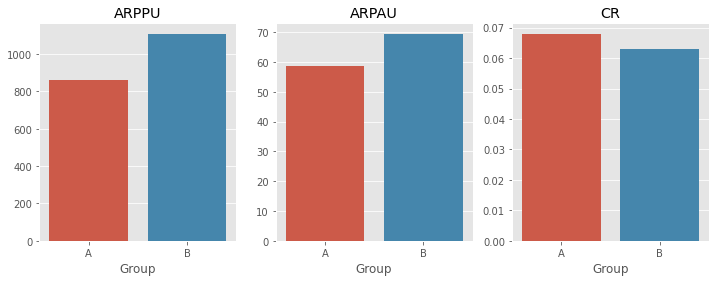

In [51]:
visual_metric(metric)